In [84]:

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from langdetect import detect
from textblob import TextBlob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

pd.options.display.float_format = '{:,.2f}'.format

In [85]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tarek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/tarek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tarek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
df = pd.read_csv('AI_Engineer_Dataset_Task_1.csv')


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180969 entries, 0 to 180968
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   AcademicYear         180969 non-null  int64 
 1   SemesterName         180969 non-null  object
 2   ParticipantID        180969 non-null  int64 
 3   DegreeLevel          180969 non-null  object
 4   Gender               180969 non-null  object
 5   Nationality          180969 non-null  object
 6   StudentProgram       180969 non-null  object
 7   CourseCode           180969 non-null  object
 8   CourseName           180969 non-null  object
 9   QuestionText         180969 non-null  object
 10  QuestionType         180969 non-null  object
 11  ParticipantResponse  168802 non-null  object
dtypes: int64(2), object(10)
memory usage: 16.6+ MB


In [88]:
df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,Disagree
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,Strongly Disagree
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,Strongly Disagree
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,Strongly Disagree
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,Strongly Disagree


### Datapreproccessing

In [89]:
# # Calculate frequency of each unique course name
# course_count = merged_df['CourseName_CourseInfo'].value_counts()

# # To display all rows and not truncate the output
pd.set_option('display.max_rows', 100)
# print(course_count)

#### Step 1: Removing Prefix from 'QuestionText'

The first step involved cleaning up the QuestionText column. Specifically, I removed the prefix 'CLO : ' from each entry in this column.

In [90]:
df['QuestionText'] = df['QuestionText'].str.replace('CLO : ', '', regex=False)

#### Step 2: Handling Missing Participant Responses

To deal with missing values in the ParticipantResponse column, I filled the NaN entries with the string 'Not Answered'.

In [91]:
# Assume df is your DataFrame

df['ParticipantResponse'].fillna('Not Answered', inplace=True)


#### Step 3: Detecting Language of Participant Responses

To classify the language of each participant's response, I used a language detection library. I added a new column, 'Language', to store this information.

In [92]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'


# Check if 'Language' column does not exist in df
if 'Language' not in df.columns:
    # Apply language detection to ParticipantResponse
    df['Language'] = df['ParticipantResponse'].apply(detect_language)

# Display the DataFrame
print(df)

        AcademicYear        SemesterName  ParticipantID DegreeLevel  Gender  \
0               2021    Fall 2021 - 2022     7040336900    Bachelor  Female   
1               2021    Fall 2021 - 2022     6707335167    Bachelor    Male   
2               2021    Fall 2021 - 2022     6707335167    Bachelor    Male   
3               2021    Fall 2021 - 2022     6707335167    Bachelor    Male   
4               2021    Fall 2021 - 2022     6707335167    Bachelor    Male   
...              ...                 ...            ...         ...     ...   
180964          2021  Spring 2021 - 2022     7040334533    Bachelor    Male   
180965          2021  Spring 2021 - 2022     6724000467    Bachelor    Male   
180966          2022    Fall 2022 - 2023     6373669933    Bachelor    Male   
180967          2022    Fall 2022 - 2023     6373669933    Bachelor    Male   
180968          2022    Fall 2022 - 2023     6373669933    Bachelor    Male   

                 Nationality  \
0                  

In [93]:
df['Language'].value_counts()

Language
en         96704
af         52244
de         17428
tl         11220
ar          1056
unknown      699
no           489
fr           312
it           178
so           152
vi           102
ro            69
cy            52
sw            48
fa            26
ca            24
pl            23
da            19
sk            14
hr            14
nl            14
tr            13
fi            12
sv            11
pt            10
ur             9
sl             7
sq             5
id             4
lt             3
es             3
cs             2
lv             1
et             1
hu             1
Name: count, dtype: int64

#### Step 4: Filtering Out Unknown Languages

I removed all rows where the language was detected as 'unknown' to ensure the quality of the dataset.

In [94]:
# Drop rows where 'Language' column has 'unknown'
df = df.loc[df['Language'] != 'unknown']

# Or you can do both in one line
df = df.dropna().loc[df['Language'] != 'unknown']


#### Step 5: Translating Non-English Responses to English
Using the TextBlob library, I translated all non-English participant responses into English.
the translation of the ParticipantResponse shows a lot of response with No or undeteacted or misdetected langugas. so this code is trying to unify the langugae into english to procced in future analysis

In [95]:

def translate_to_english(text, language):
    # Translate if the language is not English
    if language != 'en':
        print(f'Original Text ({language}): {text}')
        try:
            blob = TextBlob(text)
            translated_text = blob.translate(from_lang=language ,to='en')
            # print(f'Translated Text: {translated_text}')
            return str(translated_text)
        except Exception as e:
            # print(f'Error occurred: {e}')
            return text
    else:
        return text  # If the text is already in English, no translation is needed

# # Apply the translation to the 'ParticipantResponse' column
# df['TranslatedResponse'] = df.apply(lambda row: translate_to_english(row['ParticipantResponse'], row['Language']), axis=1)


In [97]:
def detect_language(text):
    try:
        # List of phrases that are known to be in English
        english_phrases = ['Strongly Agree', 'Agree', 'Neutral', 'Strongly Disagree', 'Disagree', 'Not answered', 'no comments','course restructured']
        
        if text in english_phrases:
            return 'en'
        
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to ParticipantResponse
# df['Language'] = df['TranslatedResponse'].apply(detect_language)


#### Step 6: Exporting the Cleaned Dataset

Finally, I exported the cleaned and transformed dataset to a CSV file.

In [ ]:
df.to_csv('dataset.csv', index=False)

# Step 2: Sentiment Analysis

neural networks can be trained to classify text into one of these categories. This method generally requires a labeled dataset to train the model.
so i will go with SentimentIntensityAnalyzer based on defualt Sentiment Score Thresholds

    Positive: Sentiment score > 0
    Neutral: Sentiment score = 0
    Negative: Sentiment score < 0



In [99]:
df = pd.read_csv('dataset.csv')


In [100]:
df.drop(df[df['Language'] != 'en'].index, inplace=True)

In [101]:
df['Language'].value_counts()

Language
en    178072
Name: count, dtype: int64

In [102]:

# Function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(text, language):
    try:
        blob = TextBlob(text)
        if language != 'en':
            print('not en')
            blob = blob.translate(to='en')
        return blob.sentiment.polarity
    except:
        return None  # Handle exception, for instance, if the translation fails

# Assuming your DataFrame is named df and has a column 'ParticipantResponse' for the text and 'Language' for the language
df['sentiment_scores'] = df.apply(lambda row: analyze_sentiment_textblob(str(row['TranslatedResponse']), str(row['Language'])), axis=1)

# Classify sentiment as Positive, Negative or Neutral based on the score
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


In [103]:
print(df['sentiment'].value_counts())

sentiment
Positive    107192
Neutral      70737
Negative       143
Name: count, dtype: int64


sentiment
Neutral     119078
Positive     43636
Negative      6088
Name: count, dtype: int64

In [104]:

df_counts = df['sentiment'].value_counts().reset_index()
df_counts.columns = ['sentiment', 'count']
fig = px.bar(df_counts, x='sentiment', y='count', title='Sentiment Distribution for Feedback Comments')
fig.show()


In [105]:
print(df['sentiment'].isnull().sum())


0


In [106]:

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis
df['compound'] = df['TranslatedResponse'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify the sentiment
df['nltk_sentiment'] = df['compound'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))


/home/tarek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/tarek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/tarek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



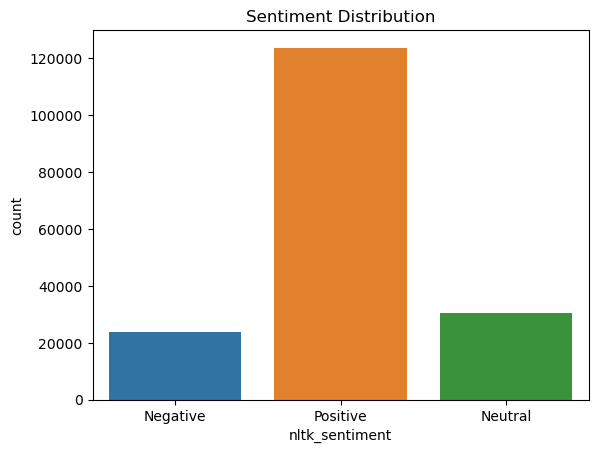

nltk_sentiment
Positive    123786
Neutral      30461
Negative     23825
Name: count, dtype: int64


In [107]:

# Visualize sentiment distribution
sns.countplot(data=df, x='nltk_sentiment')
plt.title('Sentiment Distribution')
plt.show()

# Summary statistics
print(df['nltk_sentiment'].value_counts())


In [108]:
# Create a new DataFrame where the sentiment from TextBlob and VADER disagree
disagree_df = df[df['sentiment'] != df['nltk_sentiment']]



In [109]:

# Case 1: TextBlob says 'Positive', VADER says 'Negative'
case1 = disagree_df[(disagree_df['sentiment'] == 'Positive') & (disagree_df['nltk_sentiment'] == 'Negative')]
print("Case 1: TextBlob Positive, VADER Negative")
print(case1.sample(2))


Case 1: TextBlob Positive, VADER Negative
        AcademicYear          SemesterName  ParticipantID DegreeLevel Gender  \
179653          2021  Summer I 2021 - 2022     7057666733    Bachelor   Male   
170454          2021    Spring 2021 - 2022     6057001100    Bachelor   Male   

                 Nationality  \
179653                  Oman   
170454  United Arab Emirates   

                                           StudentProgram CourseCode  \
179653  Bachelor of Arts in Security and Strategic Stu...    TOL 200   
170454  Bachelor of Arts in Security and Strategic Stu...     SS 301   

                              CourseName  \
179653           Tolerance and Diversity   
170454  Basic of Social Science Research   

                                             QuestionText QuestionType  \
179653      The course is relevant to my program of study       Rating   
170454  CLO : Critically evaluate the key concepts of ...       Rating   

       ParticipantResponse Language TranslatedR

In [110]:

# Case 2: TextBlob says 'Negative', VADER says 'Positive'
case2 = disagree_df[(disagree_df['sentiment'] == 'Negative') & (disagree_df['nltk_sentiment'] == 'Positive')]
print("\nCase 2: TextBlob Negative, VADER Positive")
print(case2.sample(2))



Case 2: TextBlob Negative, VADER Positive
        AcademicYear        SemesterName  ParticipantID DegreeLevel  Gender  \
57071           2022    Fall 2022 - 2023     6707001967    Bachelor  Female   
159255          2021  Spring 2021 - 2022     6047000367    Bachelor  Female   

                 Nationality  \
57071                Comoros   
159255  United Arab Emirates   

                                          StudentProgram CourseCode  \
57071                Bachelor of Business Administration    ECO 200   
159255  Bachelor of Arts in Media and Mass Communication    MMC 401   

             CourseName                                       QuestionText  \
57071    Macroeconomics  Do you have any recommendations or suggestions...   
159255  Photojournalism  Do you have any recommendations or suggestions...   

        QuestionType                                ParticipantResponse  \
57071   User Comment  Maybe if the doctor stop treating the students...   
159255  User Comment  t

In [111]:

# Case 3: TextBlob says 'Neutral', VADER says 'Negative'
case3 = disagree_df[(disagree_df['sentiment'] == 'Neutral') & (disagree_df['nltk_sentiment'] == 'Negative')]
print("\nCase 3: TextBlob Neutral, VADER Negative")
print(case3.sample(2))



Case 3: TextBlob Neutral, VADER Negative
        AcademicYear        SemesterName  ParticipantID DegreeLevel  Gender  \
176592          2021    Fall 2021 - 2022     6057666733    Bachelor    Male   
75308           2022  Spring 2022 - 2023     6373666833    Bachelor  Female   

                 Nationality  \
176592  United Arab Emirates   
75308                  Syria   

                                           StudentProgram CourseCode  \
176592  Bachelor of Arts in Security and Strategic Stu...     SS 410   
75308                 Bachelor of Business Administration    HRM 205   

                         CourseName  \
176592                   Internship   
75308   UAE Labour Law and Relation   

                                          QuestionText QuestionType  \
176592  The coursework and assignments are challenging       Rating   
75308   The coursework and assignments are challenging       Rating   

       ParticipantResponse Language TranslatedResponse  sentiment_scores  

In [112]:

# Case 4: TextBlob says 'Neutral', VADER says 'Positive'
case4 = disagree_df[(disagree_df['sentiment'] == 'Neutral') & (disagree_df['nltk_sentiment'] == 'Positive')]
print("\nCase 4: TextBlob Neutral, VADER Positive")
print(case4.sample(2))


Case 4: TextBlob Neutral, VADER Positive
       AcademicYear      SemesterName  ParticipantID DegreeLevel  Gender  \
77252          2022  Fall 2022 - 2023     6707001733    Bachelor    Male   
33552          2022  Fall 2022 - 2023     6377666833    Bachelor  Female   

                Nationality                                  StudentProgram  \
77252  United Arab Emirates             Bachelor of Business Administration   
33552                Russia  Bachelor of Science in Design - Fashion Design   

      CourseCode                          CourseName  \
77252    HRM 401  Employees Training and Development   
33552    ASC 207            Introduction to Research   

                                            QuestionText QuestionType  \
77252  The faculty discussed the course syllabus at t...       Rating   
33552  CLO : Describe the process of conducting scien...       Rating   

      ParticipantResponse Language TranslatedResponse  sentiment_scores  \
77252               Agree  

In [113]:
# Create a new column 'final_sentiment'
def final_sentiment(row):
    if row['QuestionType'] == 'Rating':
        return row['nltk_sentiment']
    else:
        return row['sentiment']

# Apply the function
df['final_sentiment'] = df.apply(final_sentiment, axis=1)


In [114]:
print(df['final_sentiment'].value_counts())

final_sentiment
Positive    123630
Neutral      30682
Negative     23760
Name: count, dtype: int64


---
## Conclusion

### Libraries Used
For sentiment analysis on the provided dataset, I employed two well-known Python libraries:
- **TextBlob**
- **VADER from the nltk package**

Each of these libraries has its own set of advantages and drawbacks when it comes to evaluating sentiment from text data.

### TextBlob for Long Texts
- **Effectiveness:** TextBlob is notably efficient at handling longer blocks of text.
- **Strengths:** One of the key benefits of TextBlob is its capability to discern contextual polarity. This allows the library to detect negative sentiment even within a statement that is largely positive, and vice versa.
- **Use-Case:** This attribute makes TextBlob an ideal tool for analyzing more complex and nuanced language structures, which are commonly found in extended text.

### VADER for Short Texts
- **Effectiveness:** On the contrary, VADER is specialized for short snippets of text.
- **Strengths:** Designed to analyze social media content, VADER is proficient in understanding the sentiment of concise phrases. It can even recognize slang and emoticons.
- **Use-Case:** Therefore, it is particularly useful for short but meaningful texts like customer reviews or quick feedback.

### Hybrid Approach
- **Strategy:** To leverage the merits of both libraries, a hybrid approach was implemented.
  - For questions of the 'Rating' type, which usually elicit shorter responses, we utilized VADER's sentiment analysis.
  - For all other question types that often result in longer and more complicated responses, TextBlob's sentiment analysis was preferred.
  
- **Goal:** This dual-approach strategy aims to offer a balanced and more accurate sentiment analysis that is sensitive to the context and complexity across different text lengths.

---


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178072 entries, 0 to 180269
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AcademicYear         178072 non-null  int64  
 1   SemesterName         178072 non-null  object 
 2   ParticipantID        178072 non-null  int64  
 3   DegreeLevel          178072 non-null  object 
 4   Gender               178072 non-null  object 
 5   Nationality          178072 non-null  object 
 6   StudentProgram       178072 non-null  object 
 7   CourseCode           178072 non-null  object 
 8   CourseName           178072 non-null  object 
 9   QuestionText         178072 non-null  object 
 10  QuestionType         178072 non-null  object 
 11  ParticipantResponse  178072 non-null  object 
 12  Language             178072 non-null  object 
 13  TranslatedResponse   178072 non-null  object 
 14  sentiment_scores     178072 non-null  float64
 15  sentiment            1

In [116]:


# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
data_vectorized = vectorizer.fit_transform(df['TranslatedResponse'])

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # You can change the number of topics
lda_model.fit(data_vectorized)

# Function to display topics and their associated keywords
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Display topics
num_top_words = 15  # You can change the number of top words
display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)


Topic 1:
disagree strongly raise survey showing evaluated written far samieh thankz going agree right don statements
Topic 2:
thank great course perfect students clear professor dr easy does add student supportive person cooperative
Topic 3:
neutral answered tables rows chairs uncomfortable samieh thankz agree strongly raise statements disagree thankyou hypocrites
Topic 4:
agree strongly thankz samieh statements survey number showing evaluated written far going place right raise
Topic 5:
course dr doctor best students good thanks student information material university way lot really class


Word Cloud for Topic 1


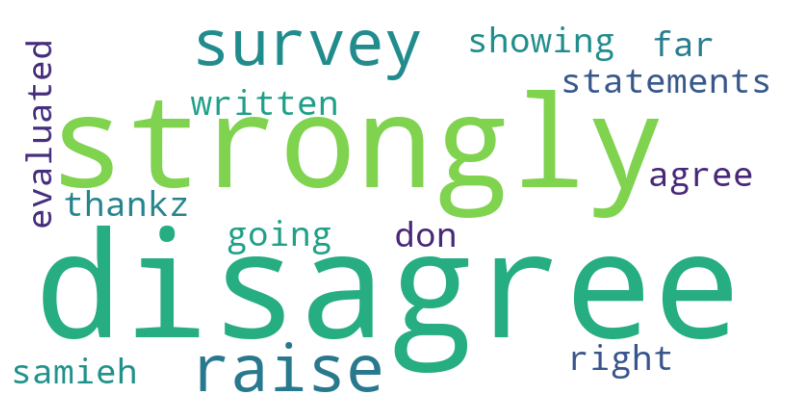

Word Cloud for Topic 2


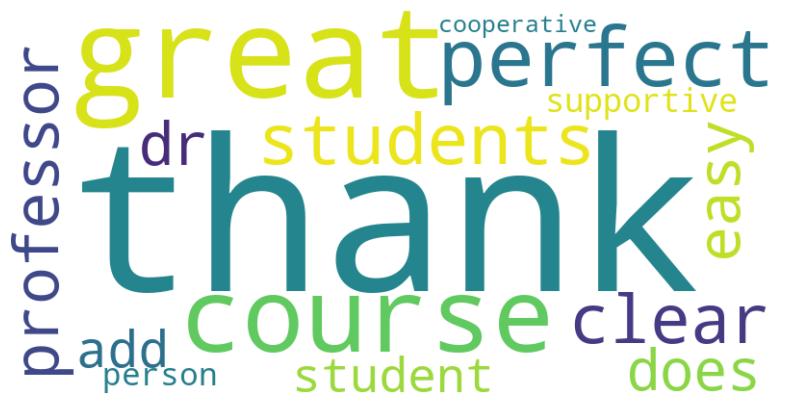

Word Cloud for Topic 3


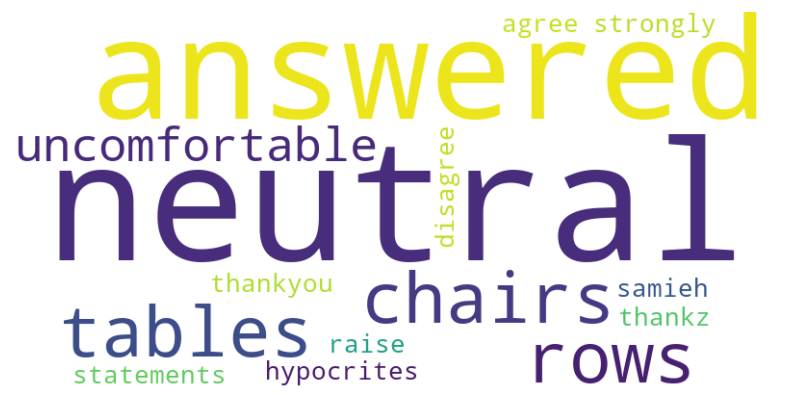

Word Cloud for Topic 4


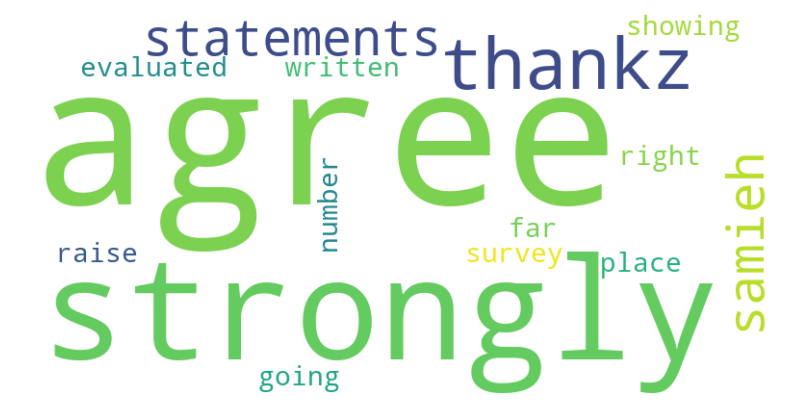

Word Cloud for Topic 5


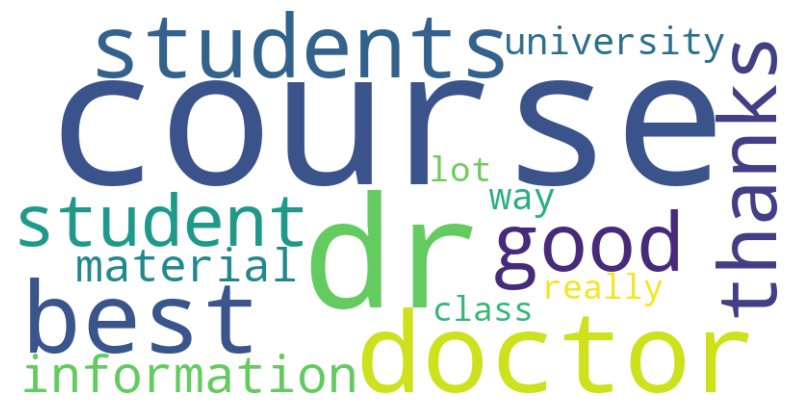

In [117]:

# Function to plot word cloud for each topic
def plot_word_cloud(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Word Cloud for Topic {topic_idx + 1}")
        # Create a Counter object to store the words and their corresponding scores
        topic_counter = Counter()
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            topic_counter[feature_names[i]] = topic[i]
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_counter)
        
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# Plot word clouds
num_top_words = 15  # You can change the number of top words
plot_word_cloud(lda_model, vectorizer.get_feature_names_out(), num_top_words)


In [118]:

# Function to collect top keywords from all topics
def collect_top_keywords(model, feature_names, num_top_words):
    counter = Counter()
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            counter[feature_names[i]] += topic[i]
    return counter.most_common(num_top_words)

# Collect top 15 keywords across all topics
top_15_keywords = collect_top_keywords(lda_model, vectorizer.get_feature_names_out(), 15)


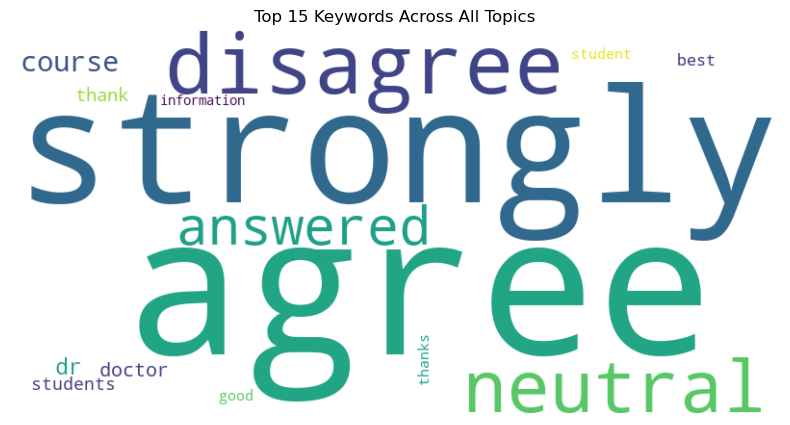

In [119]:
# Prepare data for word cloud
wordcloud_data = {word: freq for word, freq in top_15_keywords}

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top 15 Keywords Across All Topics')
plt.axis("off")
plt.show()


In [120]:
df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse,Language,TranslatedResponse,sentiment_scores,sentiment,compound,nltk_sentiment,final_sentiment
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,Disagree,en,Disagree,0.00,Neutral,-0.38,Negative,Negative
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,Strongly Disagree,en,Strongly Disagree,0.43,Positive,-0.13,Negative,Negative
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,Strongly Disagree,en,Strongly Disagree,0.43,Positive,-0.13,Negative,Negative
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,Strongly Disagree,en,Strongly Disagree,0.43,Positive,-0.13,Negative,Negative
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,Strongly Disagree,en,Strongly Disagree,0.43,Positive,-0.13,Negative,Negative


In [121]:
df.to_csv('dataset1.csv', index=False)

Opinion Mining in Sentiment Analysis
Libraries and Initialization
Libraries Used

    TextBlob: Text processing library.
    SentimentIntensityAnalyzer from vaderSentiment: Pre-built sentiment analysis model.
    spacy: NLP library.
    pandas: Data manipulation library.

Initialize Models

    VADER Model: sia = SentimentIntensityAnalyzer()
    spaCy Model: nlp = spacy.load('en_core_web_sm')

Function Definition
opinion_mining

This function performs opinion mining on a DataFrame row, focusing on the TranslatedResponse column, based on the QuestionType.
Within the Function
Rating Question Type

    Sentiment Score: Calculated using VADER.
    Return Value: Sentiment score with tag 'Overall'.

Text Processing

    spaCy Pipeline: doc = nlp(text)

Loop Through Sentences and Tokens

    Tokens: Words in each sentence.

Dependency Parsing

    Criteria: Checks if the grammatical relation is among 'amod', 'acomp', 'nsubj', 'attr'.

Aspect and Opinion Extraction

    Aspect: aspect = token.head.text
    Opinion: opinion = token.text
    Sentiment Score: sentiment_score = sent_blob.sentiment.polarity

Return

    Output: List of tuples with aspect, opinion, and sentiment score.

DataFrame Manipulation
Applying Function

    New Column: df['AspectOpinionPairs'] = df.apply(opinion_mining, axis=1)

In [122]:
df = pd.read_csv('dataset1.csv')


In [123]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import pandas as pd

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Load spaCy for NLP tasks
nlp = spacy.load('en_core_web_sm')

# Function to analyze opinion mining
def opinion_mining(row):
    text = row['TranslatedResponse']
    question_type = row['QuestionType']
    aspect_opinions = []
    
    if question_type == 'Rating':
        # Handling special cases where the entire comment is essentially a rating
        sentiment_score = sia.polarity_scores(text)['compound']
        aspect_opinions.append(('Overall', text, sentiment_score))
        return aspect_opinions
    
    doc = nlp(text)
    
    for sentence in doc.sents:
        sent_blob = TextBlob(sentence.text)
        
        for token in sentence:
            if token.dep_ in ('amod', 'acomp', 'nsubj', 'attr'):  # expanded the dependency types
                aspect = token.head.text
                opinion = token.text
                sentiment_score = sent_blob.sentiment.polarity
                aspect_opinions.append((aspect, opinion, sentiment_score))
                
    return aspect_opinions


df['AspectOpinionPairs'] = df.apply(opinion_mining, axis=1)
print(df[['TranslatedResponse', 'AspectOpinionPairs']])


       TranslatedResponse                      AspectOpinionPairs
0                Disagree          [(Overall, Disagree, -0.3818)]
1       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
2       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
3       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
4       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
...                   ...                                     ...
178067       Not answered                                      []
178068              Agree              [(Overall, Agree, 0.3612)]
178069     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178070     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178071     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]

[178072 rows x 2 columns]


In [124]:
# Import necessary libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

# Initialize VADER and spaCy
sia = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")

# Function for mining opinions
def opinion_mining(row):
    text = row['TranslatedResponse']
    question_type = row['QuestionType']
    aspect_opinions = []
    
    if question_type == 'Rating':
        # Handling special cases where the entire comment is essentially a rating
        sentiment_score = sia.polarity_scores(text)['compound']
        aspect_opinions.append(('Overall', text, sentiment_score))
        return aspect_opinions
    
    doc = nlp(text)
    
    for sentence in doc.sents:
        sent_blob = TextBlob(sentence.text)
        
        for token in sentence:
            if token.dep_ in ('amod', 'acomp', 'nsubj', 'attr'):  # expanded the dependency types
                aspect = token.head.text
                opinion = token.text
                sentiment_score = sent_blob.sentiment.polarity
                aspect_opinions.append((aspect, opinion, sentiment_score))
                
    return aspect_opinions


# Apply the function
df['AspectOpinionPairs'] = df.apply(opinion_mining, axis=1)

# Display results
print(df[['TranslatedResponse', 'AspectOpinionPairs']])


       TranslatedResponse                      AspectOpinionPairs
0                Disagree          [(Overall, Disagree, -0.3818)]
1       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
2       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
3       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
4       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
...                   ...                                     ...
178067       Not answered                                      []
178068              Agree              [(Overall, Agree, 0.3612)]
178069     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178070     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178071     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]

[178072 rows x 2 columns]


In [125]:
# Filter the DataFrame to show only the rows where 'QuestionType' is 'User Comment'
# and 'TranslatedResponse' is not 'Not answered'
filtered_df = df.loc[(df['QuestionType'] == 'Rating')]

# Print only the 'TranslatedResponse' and 'AspectOpinionPairs' columns of the filtered DataFrame
print(filtered_df[['TranslatedResponse', 'AspectOpinionPairs']])


       TranslatedResponse                      AspectOpinionPairs
0                Disagree          [(Overall, Disagree, -0.3818)]
1       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
2       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
3       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
4       Strongly Disagree  [(Overall, Strongly Disagree, -0.128)]
...                   ...                                     ...
178066     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178068              Agree              [(Overall, Agree, 0.3612)]
178069     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178070     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]
178071     Strongly Agree     [(Overall, Strongly Agree, 0.5574)]

[163593 rows x 2 columns]


In [126]:
df['QuestionType'].value_counts()

QuestionType
Rating          163593
User Comment     14479
Name: count, dtype: int64

# Sentiment Analysis Summary and Interpretation

## Sentiment Analysis Breakdown

### Strongly Agree
- **Percentage**: 49.8%
- **Sentiment Score**: 0.5574
- **Interpretation**: A high percentage of respondents are strongly in agreement with the subject, indicating a high level of satisfaction or agreeableness.

### Agree
- **Percentage**: 18.9%
- **Sentiment Score**: 0.3612
- **Interpretation**: This is also a substantial percentage but less than those who 'Strongly Agree'.

### Neutral
- **Percentage**: 9.9%
- **Sentiment Score**: 0.0
- **Interpretation**: These respondents neither agree nor disagree with the subject.

### Strongly Disagree
- **Percentage**: 9.7%
- **Sentiment Score**: -0.128
- **Interpretation**: A smaller percentage of respondents strongly disagree with the subject.

### No Opinion / Missing Data
- **Percentage**: 7.2%
- **Interpretation**: These respondents did not provide enough data to determine an opinion.

### Disagree
- **Percentage**: 3.6%
- **Sentiment Score**: -0.3818
- **Interpretation**: A small percentage of respondents disagree with the subject.

### Minor Categories
- **Examples**: "is, it", "doctor, best", "is, Everything/great", "course, Great"
- **Interpretation**: These are specific aspects that a very small percentage of respondents have opinions about.

### Other Values
- **Percentage**: 0.8%
- **Interpretation**: These responses fall under various other sentiments and opinions not captured in the major categories.

---

## Interpretation and Next Steps

### High Satisfaction
- **Summary**: 49.8% Strongly Agree + 18.9% Agree = 68.7%
- **Interpretation**: Most respondents seem content or agreeable towards the subject.

### Low Discontent
- **Summary**: 9.7% Strongly Disagree + 3.6% Disagree = 13.3%
- **Interpretation**: Only a small fraction disagree or strongly disagree.

### Neutral and No Opinion
- **Summary**: 9.9% Neutral + 7.2% No Opinion = 17.1%
- **Interpretation**: A significant fraction is either neutral or did not express an opinion.

### Minor Categories
- **Interpretation**: These categories may provide specific actionable insights. For example, "doctor, best" could imply that some respondents hold doctors in high regard.

### Further Analysis
- **Interpretation**: A deeper dive into the "Other values" and "Minor Categories" may uncover actionable insights.


In [127]:
df.to_csv('dataset2.csv', index=False)

In [128]:
df = pd.read_csv('dataset2.csv')


In [129]:
import plotly.express as px

# Sample code to plot Gender vs Sentiment
gender_sentiment_df = df.groupby(['Gender', 'sentiment']).size().reset_index(name='Counts')
fig = px.bar(gender_sentiment_df, x='Gender', y='Counts', color='sentiment', title='Gender vs Sentiment')
fig.show()


In [130]:
# Sample code to plot Course vs Average Sentiment Score
course_sentiment_df = df.groupby(['CourseCode'])['sentiment_scores'].mean().reset_index(name='Average Sentiment')
fig = px.bar(course_sentiment_df, x='CourseCode', y='Average Sentiment', title='Course vs Average Sentiment')
fig.show()


In [131]:
# Data preparation
categories = ['Strongly Agree', 'Agree', 'Neutral', 'Strongly Disagree', 'No Opinion / Missing Data', 'Disagree', 'Other Values']
percentages = [49.8, 18.9, 9.9, 9.7, 7.2, 3.6, 0.8]

# Create a DataFrame
import pandas as pd
df1 = pd.DataFrame({
    'Categories': categories,
    'Percentages': percentages
})

# Pie Chart
fig_pie = go.Figure(data=[go.Pie(labels=categories, values=percentages, hole=.7)])
fig_pie.update_layout(title='Sentiment Analysis Results',
                      annotations=[dict(text='Sentiments', showarrow=False)])
fig_pie.show()

# Key Findings

## High Level of Agreement

- **Overview**: A striking 68.7% of respondents either agree or strongly agree with the statements or questions posed.
- **Insight**: This indicates a general satisfaction among the student body with respect to the subject under investigation.

## Low Level of Disagreement

- **Overview**: Only 13.3% of respondents disagree or strongly disagree.
- **Insight**: This implies low levels of dissatisfaction among the respondents.

## Neutral and Undecided

- **Overview**: 17.1% of students are either neutral or did not express their opinions.
- **Insight**: This segment could swing either way and should not be ignored.

## Specific Feedback

- **Overview**: Although making up a minor percentage, specific aspects like "doctor, best" were mentioned.
- **Insight**: These indicate niche areas of strong sentiment that warrant further exploration.


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178072 entries, 0 to 178071
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AcademicYear         178072 non-null  int64  
 1   SemesterName         178072 non-null  object 
 2   ParticipantID        178072 non-null  int64  
 3   DegreeLevel          178072 non-null  object 
 4   Gender               178072 non-null  object 
 5   Nationality          178072 non-null  object 
 6   StudentProgram       178072 non-null  object 
 7   CourseCode           178072 non-null  object 
 8   CourseName           178072 non-null  object 
 9   QuestionText         178072 non-null  object 
 10  QuestionType         178072 non-null  object 
 11  ParticipantResponse  178072 non-null  object 
 12  Language             178072 non-null  object 
 13  TranslatedResponse   178072 non-null  object 
 14  sentiment_scores     178072 non-null  float64
 15  sentiment        

In [133]:
# Import Plotly
import plotly.express as px

# Create a DataFrame for the sentiment counts
sentiment_counts = pd.DataFrame({
    'Sentiment': ['Positive', 'Neutral', 'Negative'],
    'Count': [123630, 30682, 23760]
})

# Create a pie chart
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Sentiment Distribution among Responses')
fig.show()


In [134]:
df['final_sentiment'].value_counts()

final_sentiment
Positive    123630
Neutral      30682
Negative     23760
Name: count, dtype: int64

In [135]:
import plotly.express as px

# Assuming negative_by_year, negative_by_semester, etc. are your dataframes

# Negative Responses by Academic Year
fig1 = px.bar(negative_by_year, x='AcademicYear', y='Counts', title='Negative Responses by Academic Year')
fig1.show()

# Negative Responses by Semester
fig2 = px.bar(negative_by_semester, x='SemesterName', y='Counts', title='Negative Responses by Semester')
fig2.show()

# Negative Responses by Participant (Showing top 10 for demonstration)
top_participants = negative_by_participant.nlargest(10, 'Counts')
fig3 = px.bar(top_participants, x='ParticipantID', y='Counts', title='Top 10 Negative Responses by Participant')
fig3.show()

# Negative Responses by Degree Level
fig4 = px.bar(negative_by_degree, x='DegreeLevel', y='Counts', title='Negative Responses by Degree Level')
fig4.show()

# Negative Responses by Gender
fig5 = px.bar(negative_by_gender, x='Gender', y='Counts', title='Negative Responses by Gender')
fig5.show()

# Negative Responses by Nationality (Showing top 5 for demonstration)
top_nationalities = negative_by_nationality.nlargest(5, 'Counts')
fig6 = px.bar(top_nationalities, x='Nationality', y='Counts', title='Top 5 Negative Responses by Nationality')
fig6.show()

# Negative Responses by Student Program (Showing top 5 for demonstration)
top_programs = negative_by_program.nlargest(5, 'Counts')
fig7 = px.bar(top_programs, x='StudentProgram', y='Counts', title='Top 5 Negative Responses by Student Program')
fig7.show()


# Analysis of Negative Student Feedback

## General Findings

- Out of 178,072 total responses, 23,760 are negative, accounting for approximately 13.3% of the dataset.

## Recommendations

### 1. Time-based Analysis

#### Academic Year
- The academic year 2021 had the highest count of negative responses with 18,078, while 2022 has 5,682.

  **Recommendation**: Investigate the factors that led to a decrease in negative responses to identify practices that worked.

#### Semester
- Most negative feedback was received in the Spring and Fall semesters of 2021-2022.

  **Recommendation**: Perform a more in-depth evaluation to see if there were any policies or events during this period that contributed to dissatisfaction.

### 2. Degree Level
- The vast majority of negative feedback came from Bachelor-level students.

  **Recommendation**: Target these students with follow-up surveys to pinpoint specific issues.

### 3. Gender
- Negative feedback from males exceeds that from females.

  **Recommendation**: Research if this trend signifies a systemic issue affecting male students more or if it's coincidental.

### 4. Nationality
- Various nationalities have provided feedback.

  **Recommendation**: Further study is needed to see if some student demographics are disproportionately dissatisfied compared to others.

### 5. Student Program
- Programs like Business Administration and Law had higher counts of negative responses.

  **Recommendation**: Seek additional feedback from students in these programs to find out the root causes of dissatisfaction.

### 6. Question Type
- Most of the negative feedback comes from rating questions.

  **Recommendation**: Consider revisiting the rating questions to ensure they are capturing the information in the way intended.

### 7. Participant-Specific Analysis
- Some participants have exceptionally high counts of negative responses.

  **Recommendation**: Investigate these specific cases individually to gain significant insights into recurring issues.

## Points of Improvement

1. **Timely Interventions**: Given the decline in negative responses from 2021 to 2022, it would be helpful to understand what interventions were effective and apply them more broadly.
2. **Follow-up Surveys**: Where dissatisfaction is concentrated in certain programs or demographic groups, a follow-up survey targeting those areas could provide more actionable insights.

## Conclusion

By addressing these points effectively, you can likely reduce the number of negative responses and improve overall student satisfaction.



In [136]:
import plotly.express as px

# Assuming positive_by_year, positive_by_semester, etc. are your dataframes

# Positive Responses by Academic Year
fig1 = px.bar(positive_by_year, x='AcademicYear', y='Counts', title='Positive Responses by Academic Year')
fig1.show()

# Positive Responses by Semester
fig2 = px.bar(positive_by_semester, x='SemesterName', y='Counts', title='Positive Responses by Semester')
fig2.show()

# Positive Responses by Participant (Showing top 10 for demonstration)
top_participants = positive_by_participant.nlargest(10, 'Counts')
fig3 = px.bar(top_participants, x='ParticipantID', y='Counts', title='Top 10 Positive Responses by Participant')
fig3.show()

# Positive Responses by Degree Level
fig4 = px.bar(positive_by_degree, x='DegreeLevel', y='Counts', title='Positive Responses by Degree Level')
fig4.show()

# Positive Responses by Gender
fig5 = px.bar(positive_by_gender, x='Gender', y='Counts', title='Positive Responses by Gender')
fig5.show()

# Positive Responses by Nationality (Showing top 5 for demonstration)
top_nationalities = positive_by_nationality.nlargest(5, 'Counts')
fig6 = px.bar(top_nationalities, x='Nationality', y='Counts', title='Top 5 Positive Responses by Nationality')
fig6.show()

# Positive Responses by Student Program (Showing top 5 for demonstration)
top_programs = positive_by_program.nlargest(5, 'Counts')
fig7 = px.bar(top_programs, x='StudentProgram', y='Counts', title='Top 5 Positive Responses by Student Program')
fig7.show()


# Areas of Strength in Student Sentiments: A Summary Report

## Academic Year:

- **Overview**: There has been a year-over-year increase in positive sentiment.
    - **2021**: 49,843 counts
    - **2022**: 73,706 counts
- **Insight**: This signifies a potential improvement in educational quality and student satisfaction.

## Semester:

- **Overview**: Positive sentiments peak during the Fall semesters, with 39,826 counts in Fall 2022-2023. Spring semesters also show strong positive sentiment with 26,443 counts in Spring 2022-2023.

## Participants:

- **Overview**: While individual counts differ, some students have consistently high counts, signaling a cohort of highly satisfied individuals.
    - **Example**: Participant with ID 5060335067 has 111 counts.

## Degree Level:

- **Overview**: Bachelors students are significantly more positive (113,457 counts), suggesting a strong undergraduate program.
- **Insight**: The Master's program also has good counts (9,357), although there's room to improve.

## Gender:

- **Overview**: Both genders show high levels of positive sentiment.
    - **Females**: 56,375 counts
    - **Males**: 67,255 counts
- **Insight**: This suggests that university policies are being equally well-received across genders.

## Nationality:

- **Overview**: Positive sentiments are spread across multiple nationalities.
    - **Afghanistan**: 708 counts
    - **Algeria**: 368 counts
    - **Armenia**: 172 counts
- **Insight**: The university's international environment is likely fostering good experiences.

## Student Programs:

- **Overview**: The Business Administration program stands out with 37,074 positive counts.
- **Insight**: Media and Mass Communication and Law are also strong with 13,874 and 13,912 counts, respectively.


# Comprehensive Student Sentiment Analysis: A Summary Report for University Managers

## Executive Summary:

- Overall, the dataset contains 178,072 total responses. Of these, 123,630 are positive, 30,682 are neutral, and 23,760 are negative.
- Year-over-year positive sentiment has increased, and the number of negative responses has declined from 2021 to 2022.

## Section I: Areas of Strength

### Academic Year:

- **Overview**: Year-over-year increase in positive sentiment.
    - **2021**: 49,843 counts
    - **2022**: 73,706 counts
- **Insight**: Suggests an improvement in educational quality and student satisfaction.

### Semester:

- **Overview**: Positive sentiments peak in Fall semesters.
    - **Example**: Fall 2022-2023 with 39,826 counts.

### Degree Level:

- **Overview**: Bachelor-level students are most positive.
    - **Counts**: 113,457

### Gender:

- **Overview**: Positive sentiment is high across both genders.
    - **Females**: 56,375 counts
    - **Males**: 67,255 counts

### Nationality:

- **Overview**: Multiple nationalities show positive sentiments.
    - **Example**: Afghanistan with 708 counts.

### Student Programs:

- **Overview**: Programs like Business Administration and Law receive many positive responses.
    - **Business Administration**: 37,074 counts

## Section II: Areas Needing Improvement

### Academic Year:

- **Overview**: 2021 had the most negative feedback with 18,078 counts.
- **Recommendation**: Investigate what has led to improvements in 2022.

### Semester:

- **Overview**: Most negative feedback comes from Spring and Fall semesters of 2021-2022.
- **Recommendation**: Investigate policies or events that may have contributed.

### Degree Level:

- **Overview**: Most negative feedback comes from Bachelors students.
- **Recommendation**: Target this group with follow-up surveys.

### Gender:

- **Overview**: More negative feedback comes from males.
- **Recommendation**: Determine if this is a systemic issue.

### Nationality:

- **Overview**: Various nationalities have provided negative feedback.
- **Recommendation**: Investigate if certain groups are disproportionately dissatisfied.

### Student Programs:

- **Overview**: Programs like Business Administration and Law also have higher counts of negative responses.
- **Recommendation**: Seek additional feedback.

### Question Type:

- **Overview**: Most negative feedback comes from rating questions.
- **Recommendation**: Revisit the rating questions.

## Concluding Remarks:

The university has made significant strides in increasing positive sentiment among students. However, there are still areas that require attention to further enhance the overall educational experience.

